# Crop Type Classification - ML model building and optimisation

This notebook demonstrates how to build and tune machine learning models to classify crop types on NDVI timeseries and bhuvan fasal GT. Along with using all 14 NDVI features, we are also evaluating the minimum number of features required for classification so that we are able to generate crop map reports earlier. 

### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda create --name 'env_name' --file requirements.txt
$ conda activate 'env_name'
```

### Key Libraries:

- [XGBoost](https://xgboost.readthedocs.io/en/stable/): ML model for crop type classification.
- [Geopandas](https://geopandas.org/en/stable/docs.html), [Pandas]((https://xgboost.readthedocs.io/en/stable/)): Data handling and manipulation.
- [Matplotlib](https://matplotlib.org/stable/index.html), [Seaborn](https://seaborn.pydata.org/tutorial.html): Utilized for data visualization.
- [Scikit-learn](https://scikit-learn.org/stable/user_guide.html): For scaling data, obtaining relevant metrics etc.

### Modelling details:
- Model Type: XGBoost
- ML Task: Multiclass classification
- Crop Types (Target): mustard, wheat and potato
- Target Metric: harmonic mean of precision w.r.t each crop class. Formula: 3/(1/PrMustard + 1/PrWheat + 1/PrPotato) (Note: Pr is Precision)

--------

# Module and data imports

In [2]:
import os

try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-1]))
    kernel_is_loaded = True

from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import random
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 20

# Seeding
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

In [3]:
# Importing train, validation and test sets. 

train = pd.read_csv('data_files/train.csv')
val = pd.read_csv('data_files/val.csv')
test = pd.read_csv('data_files/test.csv')

# Predictor and label split

In [4]:
X_train = train.drop('crop_name', axis=1)
y_train = train['crop_name']

X_val = val.drop('crop_name', axis=1)
y_val = val['crop_name']

X_test = test.drop('crop_name', axis=1)
y_test = test['crop_name']

# Modelling

In [5]:
# Model Training and Tuning

fort_nights = list(X_train.loc[:, 'oct_1f':'apr_2f'].columns)

params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

param_grid = list(ParameterGrid(params))
max_precision_scores = []
best_params = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    precision_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1,2])
        precision_scores.append(precision)
        
    precision_scores = pd.DataFrame(precision_scores)
    hms = precision_scores.apply(lambda row : len(row) / np.sum(1.0 / row), axis=1).values
    best_hm = np.max(hms)
    if best_hm != 0:
        best_hm_idx = np.argmax(hms)
        best_params.append(param_grid[best_hm_idx])
        max_precision_scores.append(best_hm)    
        fns_used.append('-'.join(map(str, temp_X_train.columns[[0,-1]])))
        print(i , 'fns dropped completed with best harmonic mean of', best_hm, 'precision on validation data')
    else:
        print(i , 'fns dropped completed and unable to find atleast 0.85 precision on validation data w.r.t each class')
    
    i += 1
    
print('Done!!')

0 fns dropped completed with best harmonic mean of 0.9556030777742142 precision on validation data
1 fns dropped completed with best harmonic mean of 0.94932243263713 precision on validation data
2 fns dropped completed with best harmonic mean of 0.9490517468146557 precision on validation data
3 fns dropped completed with best harmonic mean of 0.9454859680352423 precision on validation data
4 fns dropped completed with best harmonic mean of 0.9371229862022741 precision on validation data
5 fns dropped completed with best harmonic mean of 0.9260370076911059 precision on validation data
6 fns dropped completed with best harmonic mean of 0.904642724478578 precision on validation data
7 fns dropped completed with best harmonic mean of 0.9031361091058218 precision on validation data
8 fns dropped completed with best harmonic mean of 0.8932522941901966 precision on validation data
9 fns dropped completed with best harmonic mean of 0.8735796916891355 precision on validation data
10 fns droppe

In [6]:
# Best precision scores obtained on validation sets. 
max_precision_scores

[0.9556030777742142,
 0.94932243263713,
 0.9490517468146557,
 0.9454859680352423,
 0.9371229862022741,
 0.9260370076911059,
 0.904642724478578,
 0.9031361091058218,
 0.8932522941901966,
 0.8735796916891355,
 0.8475964363839581]

In [7]:
# Testing the best classifiers on Unseen/Test sets. 

test_reports = []
test_precision_scores = []
confusion_matrices = []
best_models = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**best_params[i])
    
    strt_fn, end_fn = fns_used[i].split('-')
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train)
    best_models.append(best_classifier)
    test_pred = best_classifier.predict(temp_X_test)
    report = classification_report(y_test, test_pred, target_names=['Mustard', 'Wheat','Potato'], output_dict=True)
    df = pd.DataFrame(report).transpose().loc[:'Potato',:'f1-score']
    test_reports.append(df)
    test_precision_scores.append(df['precision'].values)
    print(fns_used[i])
    display(test_reports[i])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Mustard', 1:'Wheat',2:'Potato'}).rename({0:'Mustard', 1:'Wheat',2:'Potato'}, axis=1)
    confusion_matrices.append(cf)

oct_1f-apr_2f


,precision,recall,f1-score
Mustard,0.911392,0.932642,0.921895
Wheat,0.994045,0.994045,0.994045
Potato,0.963696,0.949593,0.956593


oct_1f-apr_1f


,precision,recall,f1-score
Mustard,0.909320,0.935233,0.922095
Wheat,0.994054,0.995648,0.994851
Potato,0.963149,0.934959,0.948845


oct_1f-mar_2f


,precision,recall,f1-score
Mustard,0.895939,0.914508,0.905128
Wheat,0.994271,0.993816,0.994044
Potato,0.947455,0.938211,0.942810


oct_1f-mar_1f


,precision,recall,f1-score
Mustard,0.891753,0.896373,0.894057
Wheat,0.993587,0.993587,0.993587
Potato,0.936378,0.933333,0.934853


oct_1f-feb_2f


,precision,recall,f1-score
Mustard,0.878866,0.883420,0.881137
Wheat,0.991985,0.992213,0.992099
Potato,0.941176,0.936585,0.938875


oct_1f-feb_1f


,precision,recall,f1-score
Mustard,0.872727,0.870466,0.871595
Wheat,0.991523,0.991296,0.991410
Potato,0.914100,0.917073,0.915584


oct_1f-jan_2f


,precision,recall,f1-score
Mustard,0.849206,0.831606,0.840314
Wheat,0.986974,0.989235,0.988103
Potato,0.877651,0.874797,0.876221


oct_1f-jan_1f


,precision,recall,f1-score
Mustard,0.809278,0.813472,0.811370
Wheat,0.986524,0.989235,0.987877
Potato,0.873544,0.853659,0.863487


oct_1f-dec_2f


,precision,recall,f1-score
Mustard,0.792818,0.743523,0.767380
Wheat,0.974446,0.986945,0.980655
Potato,0.837050,0.793496,0.814691


oct_1f-dec_1f


,precision,recall,f1-score
Mustard,0.785124,0.738342,0.761015
Wheat,0.964077,0.983509,0.973696
Potato,0.816364,0.730081,0.770815


oct_1f-nov_2f


,precision,recall,f1-score
Mustard,0.738028,0.678756,0.707152
Wheat,0.928556,0.991296,0.958901
Potato,0.840456,0.479675,0.610766


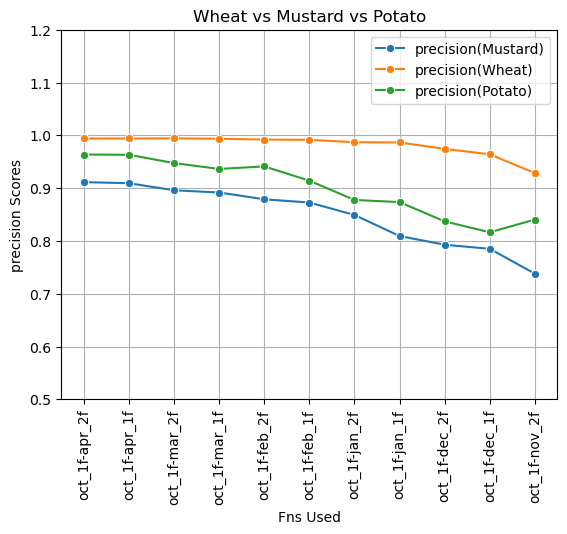

In [8]:
# Lineplots for precisions w.r.t each crop class. 

sns.lineplot(y=np.array(test_precision_scores)[:,0], x=fns_used, label='precision(Mustard)', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,1], x=fns_used, label='precision(Wheat)', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,2], x=fns_used, label='precision(Potato)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('precision Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Mustard vs Potato')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

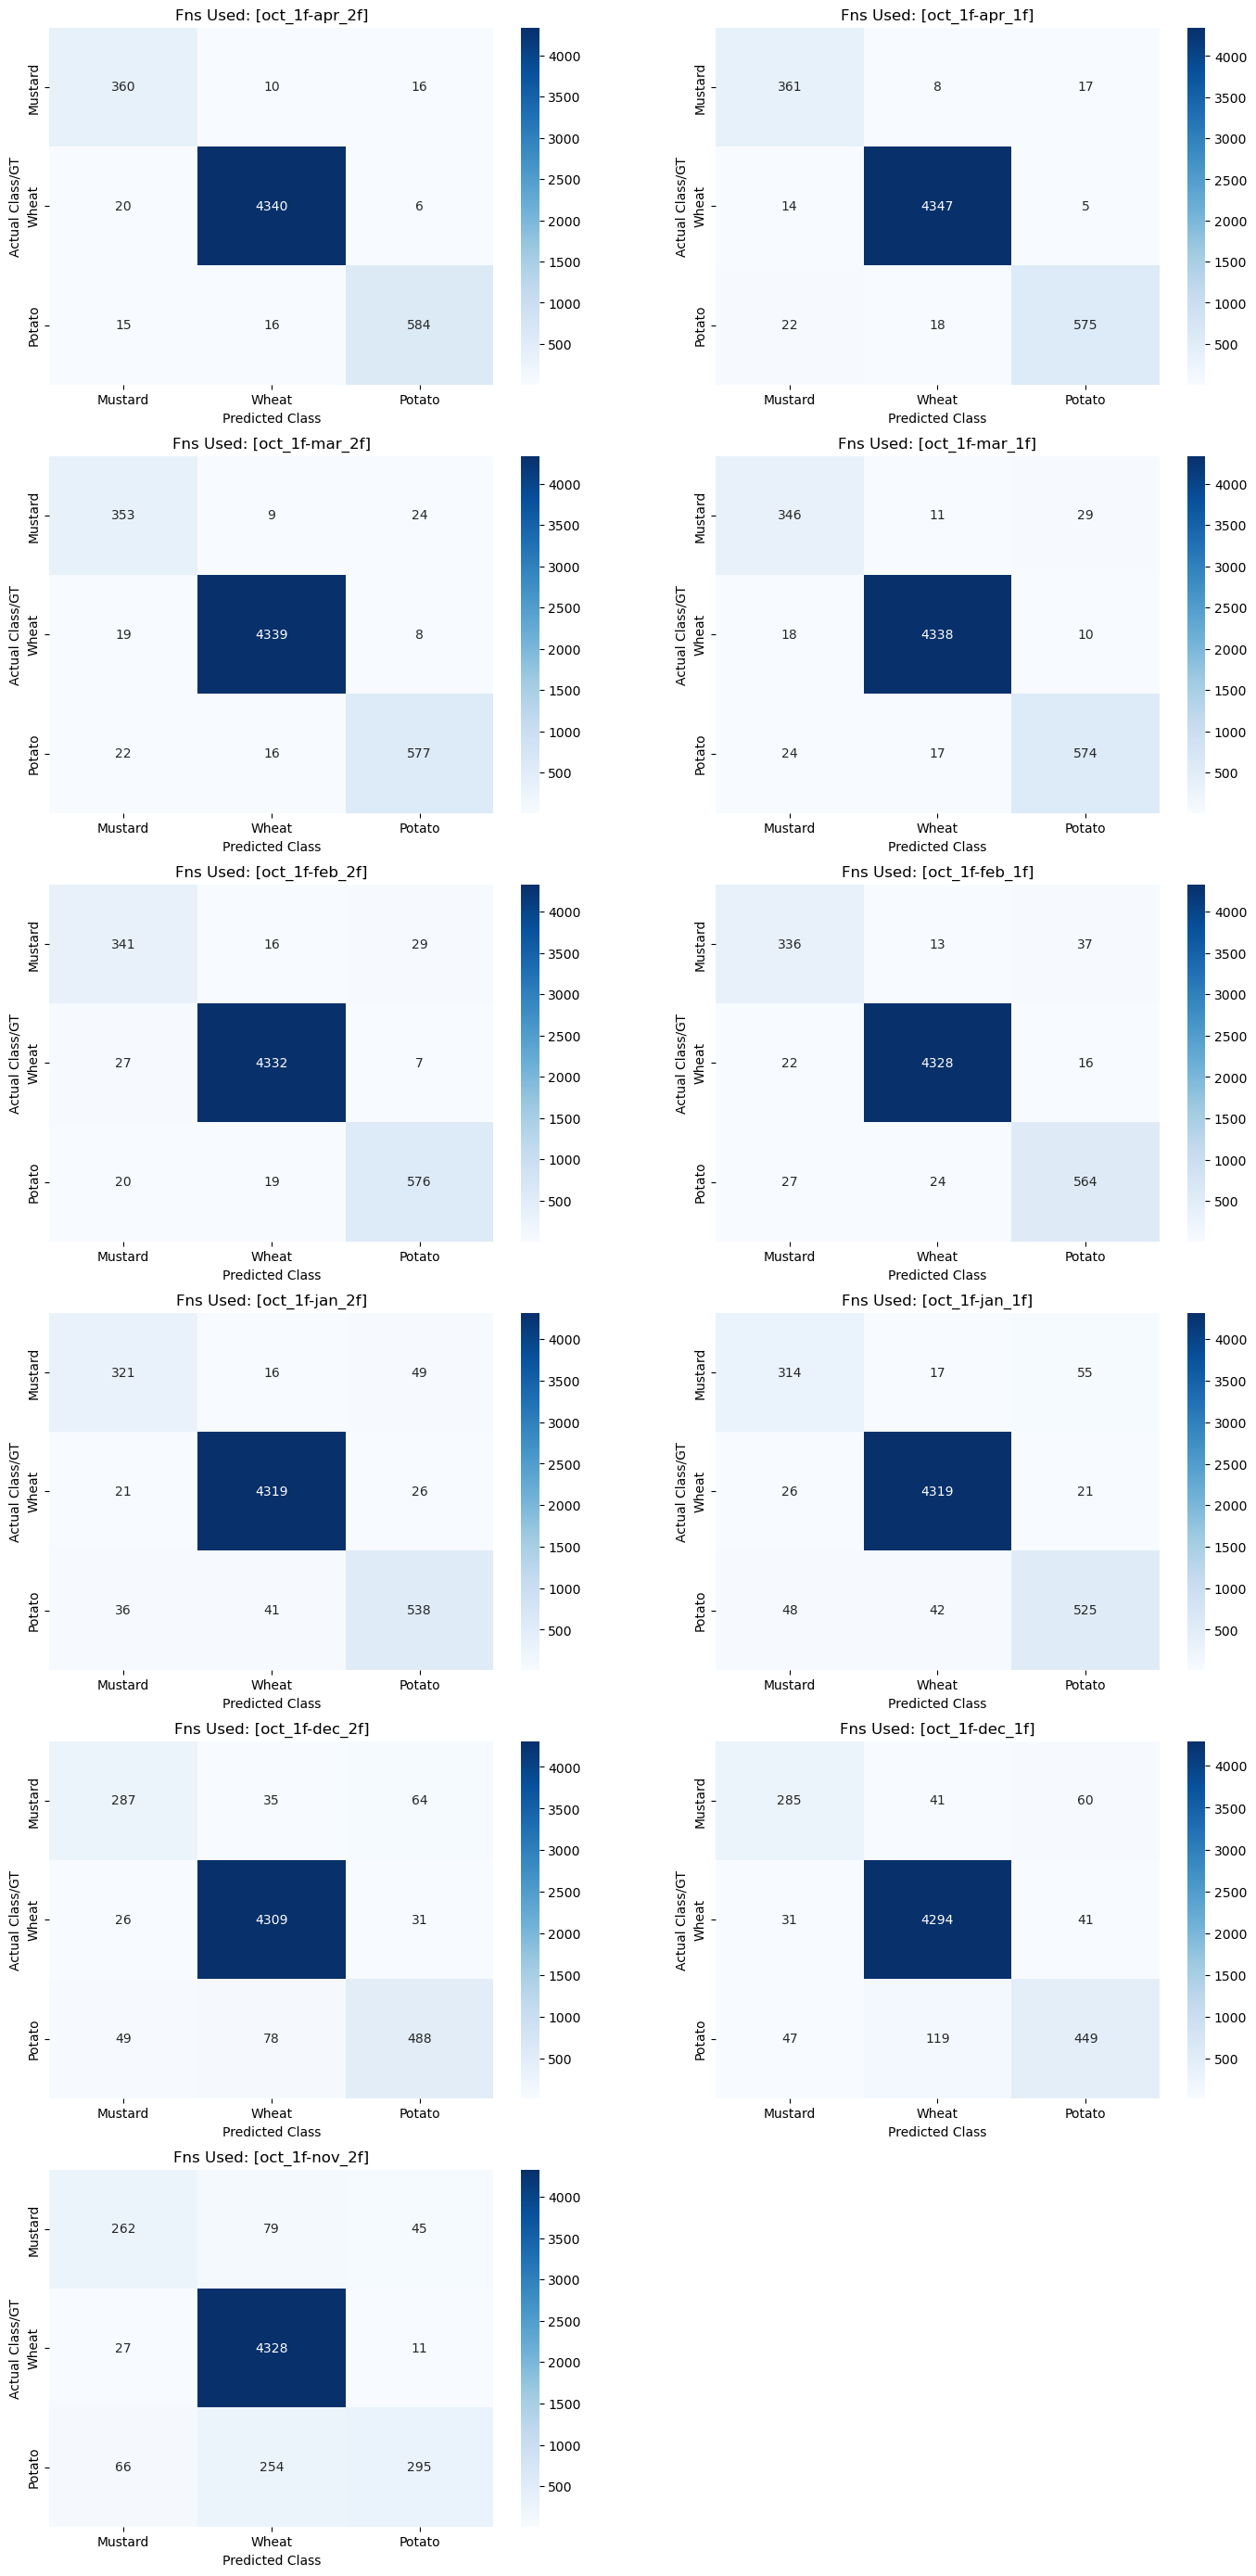

In [9]:
# Confusion matrices

plt.figure(figsize=(17,35))

for i in range(len(confusion_matrices)):
    plt.subplot(6,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()